In [1]:
# !pip3 install wordcloud

In [2]:
import nltk
from nltk.tokenize import sent_tokenize
from nltk.tokenize import word_tokenize

import gensim
from gensim import corpora
from gensim import similarities
from gensim import models
from gensim.models import CoherenceModel

# from wordcloud import WordCloud, ImageColorGenerator
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import re
import os
import datetime

import warnings

warnings.filterwarnings("ignore")

from pprint import pprint
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis

In [3]:
print(datetime.datetime.now())

2024-04-14 14:59:03.349141


/Users/wyf/miniconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


# Import the data with full news content

In [58]:
df = pd.read_parquet("processed_data1.parquet")

In [5]:
df.head()

/Users/wyf/miniconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


id                                           Headline  \
0   1.0  Grasberg Mine- Grasberg mine workers extend st...   
1   3.0  Shanghai port congestion impacts terminals in ...   
2   5.0  UPDATE - Indonesia: Police confirm two explosi...   
3   6.0  UPDATE - Indonesia: Severe winds damage infras...   
4  14.0  2 miles E of Chesterfield - A tornado has touc...   

                                             Details  Severity  \
0  Media sources indicate that workers at the Gra...  Moderate   
1  The persisting port congestion at Shanghai’s Y...     Minor   
2  According to local police in Jakarta, two expl...   Extreme   
3  Severe winds have downed billboards and trees ...  Moderate   
4  Government sources are reporting a tornado has...     Minor   

                                            Category         Region  \
0                                Mine Workers Strike      Indonesia   
1                                    Port Congestion          China   
2                         Bombing, Police Operations      Indonesia   
3  Roadway Closure / Disruption, Flooding, Severe...      Indonesia   
4                                            Tornado  United States   

        Datetime    Year       lat        lon  ...  if_labeled Month  Week  \
0  28/5/17 17:08  2017.0  -4.05608  137.11302  ...       False   5.0  21.0   
1   27/4/17 9:16  2017.0  29.52000  121.33190  ...       False   4.0  17.0   
2  24/5/17 16:20  2017.0       NaN        NaN  ...        True   5.0  21.0   
3   19/4/17 9:10  2017.0  -6.91264  107.65700  ...        True   4.0  16.0   
4  17/9/18 19:55  2018.0  37.51000  -77.61000  ...        True   9.0  38.0   

                                    Headline_Details  \
0  Grasberg Mine- Grasberg mine workers extend st...   
1  Shanghai port congestion impacts terminals in ...   
2  UPDATE - Indonesia: Police confirm two explosi...   
3  UPDATE - Indonesia: Severe winds damage infras...   
4  2 miles E of Chesterfield - A tornado has touc...   

                                                 url  \
0  https://news.google.com/rss/articles/CBMiZ2h0d...   
1  https://news.google.com/rss/articles/CBMiVWh0d...   
2  https://news.google.com/rss/articles/CBMiZWh0d...   
3  https://news.google.com/rss/articles/CBMiSWh0d...   
4  https://news.google.com/rss/articles/CBMigAFod...   

                                               title  \
0  Freeport Indonesia mine workers extend strike ...   
1  Typhoon Muifa to shut China ports for second t...   
2  Jakarta Police Receive 2 More Reports on Coldp...   
3  Indonesia hit by some of strongest winds recorded   
4  UPDATE: Number of homes without power down to ...   

                                             content  \
0  Trucks are seen on a road in the Grasberg copp...   
1  By Sam Whelan 13/09/2022\n\nAnother typhoon ha...   
2  TEMPO.CO, Jakarta - South Jakarta Metro Police...   
3  A man stands near damaged houses following a t...   
4  More than 90,000 homes and businesses across t...   

                                     cleaned_content  \
0  [truck, be, see, on, road, in, grasberg, coppe...   
1  [by, sam, whelan, typhoon, have, prompt, port,...   
2  [jakarta, south, jakarta, metro, police, recei...   
3  [man, stand, near, damage, house, follow, torn...   
4  [more, than, home, business, across, richmond,...   

                                      binary_content word_count  
0  [adkerson_jakarta_try, agreement_freeport_indo...         53  
1  [additional_ripple_effect, avoid_path_typhoon,...         44  
2  [actress_accord, available_day_concert, click_...         24  
3  [bbc_indonesia, climatologist_government_resea...         28  
4  [advise_seek_alternate, affect_richmond, alter...        134  

[5 rows x 23 columns]

In [6]:
df.shape

/Users/wyf/miniconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


(3555, 23)

# Vectorisation

NLP vectorization refers to the process of converting text data into numerical vectors that machine learning algorithms can understand and process. 

Bag-of-Words (BoW) is used here that represents text as a collection of unique words along with their frequencies. Each word is assigned an index, and the vector contains the count of each word present in the document.

In [7]:
df_copy = df.copy()

/Users/wyf/miniconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [8]:
# choose only the extreme and severe cases for modelling
cleaned = df_copy[df_copy["Severity"].isin(["Extreme", "Severe"])]
cleaned.reset_index(drop=True, inplace=True)

/Users/wyf/miniconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [9]:
headline = cleaned.binary_content

/Users/wyf/miniconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [10]:
headline[5]

/Users/wyf/miniconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


array(['amish_family', 'central_wisconsin', 'clark_county_sheriff',
       'clark_county_wi', 'close_part_state', 'community_crash_fun',
       'county_highway_j', 'crash_semi_van', 'dead_crash_wisconsin',
       'dewhurst_locate_mile', 'driver_van', 'early_information_suggest',
       'east_state_highway', 'eric_chaloux', 'eyewitness_news_none',
       'family_crash_victim', 'first_responder_work',
       'friday_morning_state', 'gross_tell_survivor', 'harm_burn',
       'highway_area_county', 'highway_direction_accord',
       'highway_j_township', 'hospital_marshville',
       'injury_law_enforcement', 'interview_milwaukee_driver',
       'investigation_wisconsin_gov', 'lavada_stout', 'man_life',
       'march_wisconsin_highway', 'miss_mom', 'north_semi',
       'office_crash_happen', 'official_tell', 'open_friday_sheriff',
       'place_stuff', 'remember_victim_authority', 'semi_head',
       'several_hour', 'sheriff_office', 'southeast_eau_claire',
       'stout_state', 'support_s

In [11]:
# vectorise the words
doc_dict = gensim.corpora.Dictionary(headline)
docs_vecs = [doc_dict.doc2bow(doc) for doc in headline]

/Users/wyf/miniconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [12]:
print("Number of unique tokens: %d" % len(doc_dict))
print("Number of articles: %d" % len(docs_vecs))

Number of unique tokens: 28944
Number of articles: 294


/Users/wyf/miniconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [13]:
# Calculate word frequencies
word_frequencies = {doc_dict[word_id]: freq for word_id, freq in doc_dict.cfs.items()}
sorted_words = sorted(word_frequencies.items(), key=lambda x: x[1], reverse=True)

pprint(sorted_words[:100])

[('heavy_rain', 14),
 ('global_supply_chain', 14),
 ('national_hurricane_center', 14),
 ('heavy_rainfall', 12),
 ('united_state', 12),
 ('port_los', 12),
 ('hong_kong', 12),
 ('critical_destination_port', 11),
 ('global_port_tracker', 11),
 ('global_shipping_disruption', 11),
 ('sign_confidence_consumer', 11),
 ('upgrade_import_forecast', 11),
 ('national_weather_service', 10),
 ('social_medium', 10),
 ('moment_exception_request', 10),
 ('sorry_site', 10),
 ('technical_difficulty_please', 10),
 ('trade_statement', 9),
 ('tropical_storm', 9),
 ('help_business', 9),
 ('meet_firm', 9),
 ('website_see_service', 9),
 ('supply_chain', 8),
 ('strong_wind', 8),
 ('asian_country', 7),
 ('day_trade_asia', 7),
 ('global_demand', 7),
 ('global_economy', 7),
 ('high_yard_density', 7),
 ('inch_rain', 7),
 ('coast_port', 7),
 ('empty_container', 7),
 ('union_worker', 7),
 ('coastal_area', 6),
 ('many_area', 6),
 ('customer_demand', 6),
 ('economic_growth', 6),
 ('free_day', 6),
 ('full_network', 6),


/Users/wyf/miniconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


# LDA Modelling

We initially selected a fixed topic number for model pipelien development and benchmark model setup. Then we used the full dataset for fine-tuning and evaluation.

## Benchmark Model

In [14]:
# Build LDA benchmark model
lda_model = gensim.models.LdaMulticore(
    corpus=docs_vecs,
    id2word=doc_dict,
    num_topics=4,
    random_state=42,
    chunksize=100,
    passes=10,
    per_word_topics=True,
)

/Users/wyf/miniconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [15]:
from pprint import pprint

# Print the Keyword in the 10 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[docs_vecs]

[(0,
  '0.001*"website_see_service" + 0.001*"help_business" + 0.001*"meet_firm" + '
  '0.000*"heavy_rain" + 0.000*"port_los" + 0.000*"heavy_rainfall" + '
  '0.000*"big_ship" + 0.000*"strong_wind" + 0.000*"national_hurricane_center" '
  '+ 0.000*"national_weather_service"'),
 (1,
  '0.001*"global_shipping_disruption" + 0.001*"upgrade_import_forecast" + '
  '0.001*"sign_confidence_consumer" + 0.001*"global_port_tracker" + '
  '0.001*"global_supply_chain" + 0.000*"national_hurricane_center" + '
  '0.000*"critical_destination_port" + 0.000*"trade_statement" + '
  '0.000*"tropical_storm" + 0.000*"economic_growth"'),
 (2,
  '0.001*"moment_exception_request" + 0.001*"sorry_site" + '
  '0.001*"technical_difficulty_please" + 0.000*"united_state" + '
  '0.000*"disruption_air_traffic" + 0.000*"major_travel_disruption" + '
  '0.000*"passenger_service" + 0.000*"bus_metro_network" + '
  '0.000*"likely_disrupt_flight" + 0.000*"public_transport"'),
 (3,
  '0.000*"hong_kong" + 0.000*"coast_port" + 0.00

/Users/wyf/miniconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [16]:
# Compute Benchmark Coherence Score
coherence_model_lda = CoherenceModel(
    model=lda_model, texts=headline, dictionary=doc_dict, coherence="c_v"
)
coherence_lda = coherence_model_lda.get_coherence()
print("\nCoherence Score LDAModel: ", coherence_lda)

/Users/wyf/miniconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)



Coherence Score LDAModel:  0.5156580167169962


In [17]:
# Compute Benchmark Perplexity
perplex = lda_model.log_perplexity(docs_vecs, total_docs=None)  # For LDAModel
# a measure of how good the model is. lower the better.

print("\nPerplexity for LDAModel: ", perplex)


Perplexity for LDAModel:  -10.522998996358806


/Users/wyf/miniconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [18]:
from pprint import pprint
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis

# feed the LDA model into the pyLDAvis instance
pyLDAvis.enable_notebook()
visual = gensimvis.prepare(lda_model, docs_vecs, doc_dict)

# Save the output to the html file
pyLDAvis.save_html(visual, "topic_viz_benchmark_severe.html")

/Users/wyf/miniconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [19]:
pd.set_option("max_colwidth", 200)
# Get the topics and their top keywords into a dataframe
topics = lda_model.show_topics(num_words=6)

topic_keywords = pd.DataFrame()
for topic_id, topic in topics:
    topic_keywords.at[topic_id, "Topic Keywords"] = topic

topic_keywords["Topic ID"] = topic_keywords.index
topic_keywords

/Users/wyf/miniconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Topic Keywords  \
0                                                                 0.001*"website_see_service" + 0.001*"help_business" + 0.001*"meet_firm" + 0.000*"heavy_rain" + 0.000*"port_los" + 0.000*"heavy_rainfall"   
1  0.001*"global_shipping_disruption" + 0.001*"upgrade_import_forecast" + 0.001*"sign_confidence_consumer" + 0.001*"global_port_tracker" + 0.001*"global_supply_chain" + 0.000*"national_hurricane_center"   
2                    0.001*"moment_exception_request" + 0.001*"sorry_site" + 0.001*"technical_difficulty_please" + 0.000*"united_state" + 0.000*"disruption_air_traffic" + 0.000*"major_travel_disruption"   
3                                                                0.000*"hong_kong" + 0.000*"coast_port" + 0.000*"social_medium" + 0.000*"port_los" + 0.000*"union_worker" + 0.000*"union_pacific_maritime"   

   Topic ID  
0         0  
1         1  
2         2  
3         3

In [20]:
# break

/Users/wyf/miniconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


# Hyper-Perameter Tuning and Evaluation

Run the cells below only for re-modelling with new datasets, the whole tuning and evaluation process may take hours to run.

In [21]:
# hyper-perameter tuning (alpha and beta)
def compute_coherence_values(corpus, dictionary, k, a, b):

    lda_model = gensim.models.LdaMulticore(
        corpus=corpus,
        id2word=dictionary,
        num_topics=k,
        random_state=42,
        chunksize=100,
        passes=10,
        alpha=a,
        eta=b,
    )

    coherence_model_lda = CoherenceModel(
        model=lda_model, texts=headline, dictionary=doc_dict, coherence="c_v"
    )
    coherence = coherence_model_lda.get_coherence()
    perplex = lda_model.log_perplexity(docs_vecs, total_docs=None)

    return coherence, perplex

/Users/wyf/miniconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [22]:
# setup
import numpy as np

from gensim.models import CoherenceModel

model_list = []
coherence_values = []
perplexity_values = []
model_topics = []
alpha_result = []
beta_result = []

# topic ranges
num_topics = range(4, 13)

# Alpha parameter
alpha = list(np.arange(0.31, 1, 0.3))
alpha.append("symmetric")
alpha.append("asymmetric")

# Beta parameter
beta = list(np.arange(0.31, 1, 0.3))
beta.append("symmetric")

/Users/wyf/miniconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Rational behind the alpha and eta: https://stats.stackexchange.com/questions/37405/natural-interpretation-for-lda-hyperparameters

In [23]:
print("Topic range: ", num_topics)
print("Alpha: ", alpha)
print("Beta: ", beta)

Topic range:  range(4, 13)
Alpha:  [0.31, 0.61, 0.9099999999999999, 'symmetric', 'asymmetric']
Beta:  [0.31, 0.61, 0.9099999999999999, 'symmetric']


/Users/wyf/miniconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [24]:
import datetime
import numpy as np
from gensim.models import CoherenceModel

print(datetime.datetime.now())

for a in alpha:
    for b in beta:
        for num in num_topics:
            cv, pv = compute_coherence_values(
                corpus=docs_vecs, dictionary=doc_dict, k=num, a=a, b=b
            )

            model_topics.append(num)
            coherence_values.append(cv)
            perplexity_values.append(pv)
            alpha_result.append(a)
            beta_result.append(b)
            print(
                "#Topics: "
                + str(num)
                + ", CV Score: "
                + str(coherence_values[-1])
                + ", PV Score: "
                + str(perplexity_values[-1])
                + ", Alpha: "
                + str(alpha_result[-1])
                + ", Beta: "
                + str(beta_result[-1])
            )

print(datetime.datetime.now())

2024-04-14 14:59:24.215253


/Users/wyf/miniconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


#Topics: 4, CV Score: 0.4937577623548033, PV Score: -10.478323004526313, Alpha: 0.31, Beta: 0.31
#Topics: 5, CV Score: 0.5541567363382776, PV Score: -10.43385471040428, Alpha: 0.31, Beta: 0.31
#Topics: 6, CV Score: 0.5583581440340063, PV Score: -10.39832867553369, Alpha: 0.31, Beta: 0.31
#Topics: 7, CV Score: 0.539339746681579, PV Score: -10.391387051762422, Alpha: 0.31, Beta: 0.31
#Topics: 8, CV Score: 0.5802000843907773, PV Score: -10.373703237875723, Alpha: 0.31, Beta: 0.31
#Topics: 9, CV Score: 0.5394146721179509, PV Score: -10.356885263952421, Alpha: 0.31, Beta: 0.31
#Topics: 10, CV Score: 0.5659231559333903, PV Score: -10.36000367507295, Alpha: 0.31, Beta: 0.31
#Topics: 11, CV Score: 0.532285458710766, PV Score: -10.348691633330558, Alpha: 0.31, Beta: 0.31
#Topics: 12, CV Score: 0.5758791159524114, PV Score: -10.34564875995922, Alpha: 0.31, Beta: 0.31
#Topics: 4, CV Score: 0.5056394246858962, PV Score: -10.376932079419479, Alpha: 0.31, Beta: 0.61
#Topics: 5, CV Score: 0.587691498

The table below reveals the top 20 fine tuned models with best combinations of coherence score and perplexity score. It was sorted by the coherence score in descending order as a higher coherence score indicates a better model, and sorted the perplexity score in ascending order as a lower perplexity score indicates a better model. While coherence score evaluates the quality of the topics, the perplexity score evaluates the overall performance of the model in predicting new documents. Usually, the coherence score is a better metric to use if the goal is to obtain topics that are semantically coherent and interpretable. Perplexity score, on the other hand, is a better metric to use if the goal is to build a model that generalises well to new data, in other words, how confident the model is in predicting the new data (Sánchez-Aguayo, et al., 2022). Ultimately, we aim to get a balance between the perplexity value and coherence score when determining our final model.

In [25]:
# Find the top 20 combinations based on Coherence Score and Perplexity Score
result = pd.DataFrame(
    {
        "Topics": model_topics,
        "Coherence Score": coherence_values,
        "Perplexity Score": perplexity_values,
        "Alpha": alpha_result,
        "Beta": beta_result,
    }
)
result.sort_values(
    by=["Coherence Score", "Perplexity Score"], ascending=[False, True]
).head(20)

/Users/wyf/miniconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Topics  Coherence Score  Perplexity Score       Alpha       Beta
87       10         0.651595        -10.424244        0.91       0.61
176       9         0.635845        -10.475434  asymmetric  symmetric
175       8         0.630926        -10.496005  asymmetric  symmetric
171       4         0.626604        -10.519982  asymmetric  symmetric
144       4         0.626580        -10.471014  asymmetric       0.31
26       12         0.615909        -10.330987        0.31       0.91
140       9         0.614905        -10.475199   symmetric  symmetric
162       4         0.611981        -10.336193  asymmetric       0.91
69       10         0.610995        -10.600072        0.61  symmetric
146       6         0.609268        -10.386193  asymmetric       0.31
105      10         0.608031        -10.637373        0.91  symmetric
39        7         0.607421        -10.429427        0.61       0.31
78       10         0.607014        -10.463498        0.91       0.31
173       6         0.605909        -10.502364  asymmetric  symmetric
151      11         0.605171        -10.296199  asymmetric       0.31
139       8         0.604519        -10.492116   symmetric  symmetric
115      11         0.603784        -10.294463   symmetric       0.31
153       4         0.602580        -10.367545  asymmetric       0.61
57        7         0.600409        -10.361130        0.61       0.91
63        4         0.598736        -10.551716        0.61  symmetric

In [26]:
result.to_csv("lda_fine_tuning_result.csv")

/Users/wyf/miniconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/Users/wyf/miniconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Alpha
0.31                  Axes(0.125,0.125;0.775x0.755)
0.61                  Axes(0.125,0.125;0.775x0.755)
0.9099999999999999    Axes(0.125,0.125;0.775x0.755)
asymmetric            Axes(0.125,0.125;0.775x0.755)
symmetric             Axes(0.125,0.125;0.775x0.755)
dtype: object

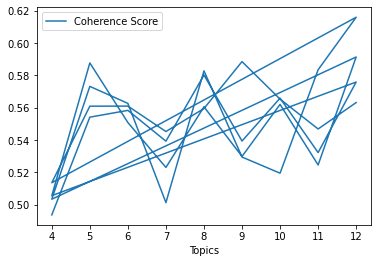

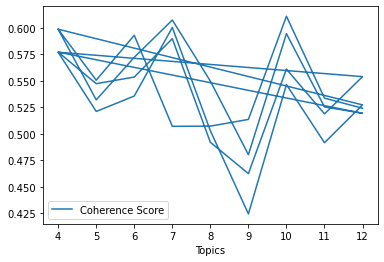

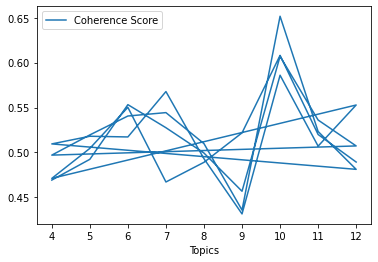

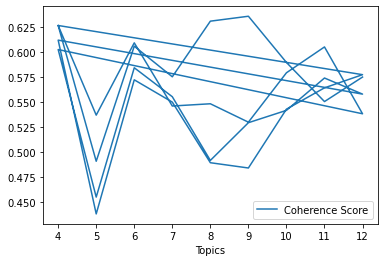

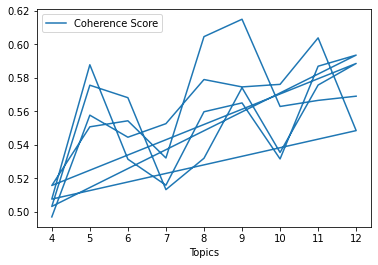

In [27]:
# Show graph Topics vs Coherence Score
result.groupby("Alpha").plot(x="Topics", y="Coherence Score", legend=True)

/Users/wyf/miniconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


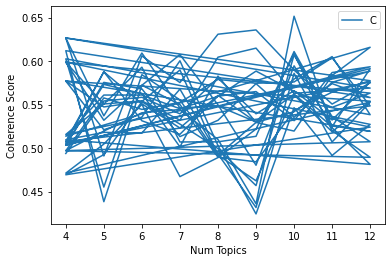

In [28]:
# Show graph Topics vs Perplexity Score

plt.plot(model_topics, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence Score")
plt.legend(("Coherence Score"), loc="best")
plt.show()

/Users/wyf/miniconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


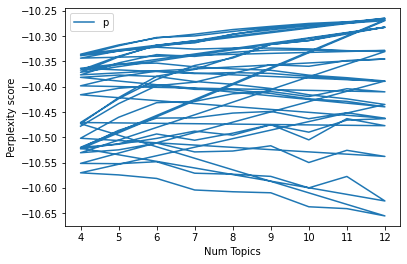

In [29]:
# Show graph Topics vs Perplexity Score

plt.plot(model_topics, perplexity_values)
plt.xlabel("Num Topics")
plt.ylabel("Perplexity score")
plt.legend(("perplexity_values"), loc="best")
plt.show()

## Final Model

Topic 4, 8, 9 and 10 were selected for further evaluation using the visual graphs, considering that the best combination does not always yield the best result since a model with higher number of topics tends to have a better measurable result but may not fit the data the most. 

However, take note that even the random_state was preset and all other parameters were fixed, there are still randomness found that the model may produce inconsistant output each time. 

unfortunately, the alter of the number of topics has no much effect on the results, and the news are not clustered into relevant topics properly. also, most topics are stacked together, indicating high similarity and ambiguity among them due to the multi-aspect nature of the news contents. As a result, LDA may not be a suitable solution for this kind of news content. same result goes for moderate and minor.

In [31]:
# realised that there may be some overlaps for 8 topics, thus 4-6 topics are optimal
k = 8
a = "asymmetric"
# a = 0.91
# b = 0.61
b = "symmetric"


final_model = gensim.models.LdaMulticore(
    corpus=docs_vecs,
    id2word=doc_dict,
    num_topics=k,
    random_state=42,
    chunksize=100,
    passes=10,
    alpha=a,
    eta=b,
)

/Users/wyf/miniconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [32]:
compute_coherence_values(corpus=docs_vecs, dictionary=doc_dict, k=k, a=a, b=b)

/Users/wyf/miniconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


(0.6309264127222964, -10.496005226704286)

In [33]:
# Set up the environment to display the graphical outputs
# feed the LDA model into the pyLDAvis instance
pyLDAvis.enable_notebook()
visual = gensimvis.prepare(final_model, docs_vecs, doc_dict)

# Save the output to the html file
pyLDAvis.save_html(visual, "topic_viz8_severe_training.html")

/Users/wyf/miniconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [34]:
final_model.print_topics(num_words=30)

/Users/wyf/miniconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


[(0,
  '0.001*"upgrade_import_forecast" + 0.001*"sign_confidence_consumer" + 0.001*"global_shipping_disruption" + 0.001*"global_port_tracker" + 0.001*"website_see_service" + 0.001*"help_business" + 0.001*"meet_firm" + 0.000*"heavy_rain" + 0.000*"united_state" + 0.000*"new_york" + 0.000*"new_york_city" + 0.000*"large_number" + 0.000*"national_hurricane_center" + 0.000*"big_ship" + 0.000*"empty_container" + 0.000*"social_medium" + 0.000*"several_hour" + 0.000*"houston_ship_channel" + 0.000*"nautical_mile" + 0.000*"second_half" + 0.000*"second_quarter" + 0.000*"makilala_town" + 0.000*"new_oil_gas" + 0.000*"country_tremor" + 0.000*"official_tell" + 0.000*"executive_director" + 0.000*"major_quake" + 0.000*"cent_world_earthquake" + 0.000*"strong_hurricane" + 0.000*"interview_milwaukee_driver"'),
 (1,
  '0.001*"sorry_site" + 0.001*"technical_difficulty_please" + 0.001*"moment_exception_request" + 0.001*"global_supply_chain" + 0.001*"economic_growth" + 0.001*"critical_destination_port" + 0.000

This allows ease access to the trained model for future prediction work.

In [ ]:
# Save a model to disk, or reload a pre-trained model
# naming convention: final_model_topic_alpha_eta
final_model.save("final_model_8_asym_sym")

get dominant topics and topic percentage contribution.
Made use of gensim lda's own function: https://radimrehurek.com/gensim/models/ldamodel.html

In [35]:
import warnings

warnings.filterwarnings("ignore")


def format_topics_sentences(ldamodel, corpus, data):
    # Preallocate memory for the DataFrame
    num_docs = len(corpus)
    sent_topics = {
        "Dominant_Topic": [0] * num_docs,
        "Perc_Contribution": [0.0] * num_docs,
        "Topic_Distribution": [()] * num_docs,
    }

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        if row:
            # Get the Dominant topic, Perc Contribution and Keywords for each document
            dominant_topic, perc_contribution = row[0]
            topic_distribution = row
            sent_topics["Dominant_Topic"][i] = int(dominant_topic)
            sent_topics["Perc_Contribution"][i] = round(perc_contribution, 4)
            sent_topics["Topic_Distribution"][i] = topic_distribution

    # Create the DataFrame
    sent_topics_df = pd.DataFrame(sent_topics)
    sent_topics_df["Text"] = data

    return sent_topics_df

/Users/wyf/miniconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [48]:
df_topic_sents_keywords = format_topics_sentences(
    ldamodel=final_model, corpus=docs_vecs, data=cleaned.Headline_Details
)

In [49]:
# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = [
    "Document_No",
    "Dominant_Topic",
    "Topic_Perc_Contrib",
    "Topic_Distribution",
    "Text",
]

# Show
df_dominant_topic.head(10)

Document_No  Dominant_Topic  Topic_Perc_Contrib  \
0            0               7              0.9627   
1            1               0              0.9799   
2            2               0              0.9551   
3            3               3              0.9740   
4            4               1              0.9705   
5            5               0              0.9851   
6            6               1              0.9975   
7            7               0              0.9653   
8            8               7              0.9893   
9            9               0              0.9893   

                    Topic_Distribution  \
0                    [(7, 0.96268755)]   
1                     [(0, 0.9799124)]   
2  [(0, 0.95514065), (1, 0.010377824)]   
3                     [(3, 0.9739527)]   
4                     [(1, 0.9704964)]   
5                     [(0, 0.9850588)]   
6                     [(1, 0.9974598)]   
7                     [(0, 0.9653319)]   
8                    [(7, 0.98926944)]   
9                     [(0, 0.9892587)]   

                                                                                                                                                                                                      Text  
0  UPDATE - Indonesia: Police confirm two explosions in East Jakarta, further casualties reported According to local police in Jakarta, two explosions have now been confirmed close to the Terminal Ka...  
1  40 miles W of Columbia- Florence continues to weaken; additional flooding expected. Incident closed. Tropical Depression Florence continues to weaken and is moving north-northwest at ten miles per...  
2  California Wildfires Cause Numerous Fatalities and Extensive Damage; Assessments are Ongoing On Tuesday, damage assessments were ongoing in areas affected by wildfires in California. The Camp Fire...  
3  Canada Post backlogs reported in Toronto, Montreal, and Vancouver Local media sources indicated on November 1 that over 150 Canada Post trailers in Toronto, Vancover, and Montreal comprise a deliv...  
4  Cargo theft network arrested for stealing USD 4 million worth of goods from truck yards On December 15, it was reported that 8 individuals from New Jersey have been arrested and a multi-million ca...  
5  Central & Southern Taiwan   Rains and floods subside as relief operations continue. Incident closed. Media sources report that heavy rainfall and flooding have subsided across central and southern...  
6  Central Tennessee - Tornadoes touched down in multiple locations across the region. Incident closed. Tornadoes were reported at multiple locations in central Tennessee, including near Hwy 11 in Pu...  
7  Coastal Virginia - The mandatory evacuations for Zone A residents have been lifted. Incident closed. The mandatory evacuations for residents in Zone A, the lowest-lying areas of Coastal Virginia a...  
8  Considerable congestion continues to be reported at Port of Long Beach Shipping sources indicate on December 5 that significant congestion is still affecting container terminals in the Port of Lon...  
9  Criminal Investigation Launched Following Genoa Bridge Collapse On Wednesday, Italian Prime Minister Giuseppe Conte declared a one-year state of emergency in the region of Liguria following the de...

# Result Analysis

In [44]:
df_dominant_topic["Dominant_Topic"].value_counts()

0    85
1    60
3    32
7    27
2    27
5    26
4    19
6    18
Name: Dominant_Topic, dtype: int64

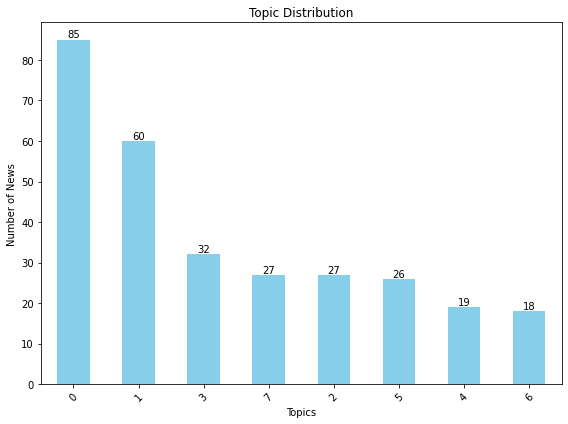

In [45]:
import matplotlib.pyplot as plt

# Get value counts of each topic
topic_counts = df_dominant_topic["Dominant_Topic"].value_counts()

# Create a bar plot
plt.figure(figsize=(8, 6))
topic_counts.plot(kind="bar", color="skyblue")

# Add labels to the bars
for i, count in enumerate(topic_counts):
    plt.text(i, count, str(count), ha="center", va="bottom")

# Add labels and title
plt.xlabel("Topics")
plt.ylabel("Number of News")
plt.title("Topic Distribution")

# Show the plot
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.tight_layout()
plt.show()

In [47]:
df_dominant_topic.sort_values(by="Topic_Perc_Contrib", ascending=False).head(20)

Document_No  Dominant_Topic  Topic_Perc_Contrib Topic_Distribution  \
36            36               0              0.9990   [(0, 0.9989845)]   
227          227               6              0.9987   [(6, 0.9986539)]   
89            89               3              0.9986  [(3, 0.99856216)]   
33            33               4              0.9985   [(4, 0.9985456)]   
43            43               4              0.9985   [(4, 0.9985456)]   
150          150               5              0.9985    [(5, 0.998542)]   
95            95               7              0.9985  [(7, 0.99846315)]   
221          221               1              0.9984   [(1, 0.9983966)]   
238          238               1              0.9984   [(1, 0.9983619)]   
236          236               1              0.9984   [(1, 0.9983966)]   
61            61               1              0.9984   [(1, 0.9983966)]   
17            17               1              0.9984   [(1, 0.9983966)]   
186          186               1              0.9983  [(1, 0.99827653)]   
282          282               2              0.9982   [(2, 0.9982014)]   
32            32               1              0.9981   [(1, 0.9980616)]   
178          178               1              0.9981   [(1, 0.9980577)]   
23            23               7              0.9979  [(7, 0.99785054)]   
124          124               3              0.9979  [(3, 0.99785566)]   
66            66               7              0.9979  [(7, 0.99787486)]   
277          277               5              0.9978  [(5, 0.99779654)]   

                                                                                                                                                  Text  
36   UPDATE - USA, North Carolina: More than a million people face mandatory evacuations along southern East Coast as Florence nears Category 5 status  
227                                                   UPDATE 1 - Vietnam monitoring more than 5,000 Chinese workers for potential signs of coronavirus  
89                                                                                                           Strong winds cause closure at Dammam Port  
33                                    UPDATE - USA, North Carolina: Hurricane Florence downgraded to Category Three as projected path shifts southward  
43                                                                       UPDATE: Hurricane Florence downgraded with states of emergency still in place  
150                                                            UPDATE: Waiting times still 5-6 days at Port of Manila as decongestion efforts continue  
95                          UPDATE - Australia: Fatalities reported due to ongoing bushfires in New South Wales and Queensland; over 125 fires burning  
221                                                           UPDATE 1 - Port closure due to low visibility at Tianjin Port further impacts operations  
238                                                                              UPDATE 2 - Waiting times increase to 5 days at the Port of Felixstowe  
236                                                               UPDATE 2 - Longer berthing times and high yard congestion reported at Port of Ningbo  
61                                                                                                    Congestion issues continue at the Port of Manila  
17                                                                       Port of Manila faces congestion due to bad weather and out-of-window arrivals  
186                                                                     Port of Busan to temporarily close for 24-hours on Oct 1 due to public holiday  
282                                   UPDATE 14 - Central North Carolina - Flooding mostly dissipated after rainfall from Hurricane Eta. Event closed.  
32                                  UPDATE - USA, District of Columbia: State of Emergency declared for Virginia in anticipation of Hu

In [56]:
# Sample 100 rows, can change the random_state for different samples
sampled_data = df_dominant_topic.sample(n=100, random_state=42)
sampled_df = pd.DataFrame(sampled_data).reset_index()
sampled_df.to_csv("sample_severe.csv")